In [45]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import make_scorer
import seaborn as sns
from sklearn.metrics import recall_score # métrica de evaluación
from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn.metrics import make_scorer, recall_score
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import sys


sys.path.insert(0, '../Code/')
from Plots import plt_validation_curve

ATENCIÓN: Disponible en sklearn 1.5 o superior

In [46]:
from sklearn.model_selection import TunedThresholdClassifierCV

In [47]:

outcome = 'outcome'
df = pd.read_csv("../datasets/raw_loan_data.csv.gz")
df.loc[df[outcome]=="paid off",[outcome]] = "aPaidOff"
le = LabelEncoder()
le.fit(df[outcome])
df.loc[:,[outcome]] = le.transform(df[outcome]).astype(int)

df.drop(columns=["Unnamed: 0", "status"], inplace=True)
predictors = ['dti', 'revol_bal', 'revol_util', 'open_acc', 
              'delinq_2yrs_zero', 'pub_rec_zero']
col_num = ["dti", "revol_bal", "revol_util", "open_acc"]
dfc = df.copy()
dfc.loc[:, col_num] = StandardScaler().fit_transform(df[col_num])
X = dfc[predictors]
y = dfc[outcome].astype(int)

knn = KNeighborsClassifier(n_neighbors=20)
knn.fit(X, y)
df.loc[:,'borrower_score_'] = knn.predict_proba(X)[:, 1]


del dfc



In [48]:
clf1 = True
X = pd.get_dummies(df[df.columns.drop(outcome)])
y = df[outcome].astype(int) #Arreglar esto
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=3, test_size=0.3)
#No selecciono el mejor clasificador porque demora mucho y no aporta a la idea que se quiere explicar
if clf1==True:
    model = DecisionTreeClassifier(max_depth=6, min_samples_leaf=4)
else:
    model = RandomForestClassifier(criterion='log_loss', max_depth=8, max_features=None,
                        min_samples_leaf=2, min_samples_split=14,
                        n_estimators=90)

model.fit(X_train, y_train)


DecisionTreeClassifier(max_depth=6, min_samples_leaf=4)

La curva ROC es una buen herramienta para analizar el comportamiento general del modelo a medida que se avanza en el porcentaje de registros positivos y verificar no solo el área bajo la curva sino tambien la existencia de un lugar en donde el modelo se vuelve peor que el azar.

No se debe descartar un escenario donde las reglas del negocio impongan un punto de corte en función de los costos asociados principalmente a comenter errores

Podemos suponer un escenario donde el coste esperado de incumplimiento de un préstamo es C, por otro lado, el rendimiento de un préstamo que se pagará es R. Finalmente el rendimiento esperado de un préstamo en general es:
𝑅𝑒𝑛𝑑𝑖𝑚𝑖𝑒𝑛𝑡𝑜=𝑃(𝑌=0)𝑅+𝑃(𝑌=1)𝐶
En lugar de simplemente etiquetar como pagado o no pagado, o determinar la propensión de incumplimiento podemos determinar si el prestamos tiene un rendimiento esperado positivo. Allí estará el punto de corte.

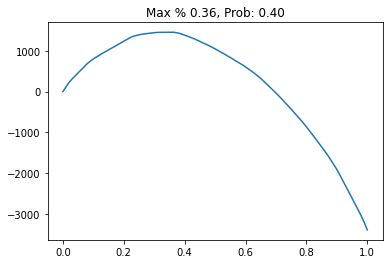

In [49]:
paidOff = 1
default = 1.5
y_df = pd.DataFrame({"y_test":y_test, 
                     "y_proba_c0":model.predict_proba(X_test)[:, 0],
                     "y_proba_ci":model.predict_proba(X_test)[:, 1]})
y_df["Rendimiento"] = y_df["y_proba_c0"]*paidOff - y_df["y_proba_ci"]*default
y_df = y_df.sort_values(by="Rendimiento", ascending=False)
thresholds = np.linspace(0, 1, 100)
rends = [np.sum(y_df.iloc[:int(t * y_df.shape[0]), :]["Rendimiento"]) for t in thresholds]
np.max(rends)
data_percent = thresholds[np.argmax(rends)]
plt.title("Max % {:.2f}, Prob: {:.2f}".format(data_percent, 
                                              y_df.iloc[int(data_percent * y_df.shape[0]), :]["y_proba_ci"]))
plt.plot(thresholds, rends)


La misma idea se puede extender a una matriz que me indique exactamente los costos o ganancias de cada situación (en este caso sin usar la proponsión). Se multiplica luego por la matriz de confusion.


In [50]:
scoring = {}
def credit_gain_score(y, y_pred, neg_label, pos_label):
    cm = confusion_matrix(y, y_pred, labels=[neg_label, pos_label])
    #Para que la matriz de confusión sea como figura en los textos
    cm = np.rot90(cm, 2)
    
    gain_matrix = np.array(
        [
            [0, -3],  # -1 gain for false positives
            [-1, 0],  # -5 gain for false negatives
        ]
    )
    return np.sum(cm * gain_matrix)

pos_label = 1
neg_label = 0

def fpr_score(y, y_pred, neg_label, pos_label):
    cm = confusion_matrix(y, y_pred, labels=[neg_label, pos_label])
    tn, fp, _, _ = cm.ravel()
    tnr = tn / (tn + fp)
    return 1 - tnr

scoring = {
    "fpr": make_scorer(fpr_score, neg_label=neg_label, pos_label=pos_label),
    "tpr": make_scorer(recall_score, pos_label=pos_label),
    "cost_gain": make_scorer(
        credit_gain_score, greater_is_better=True, neg_label=neg_label, pos_label=pos_label
    ),
}


Con los costos y ganancias asociados...

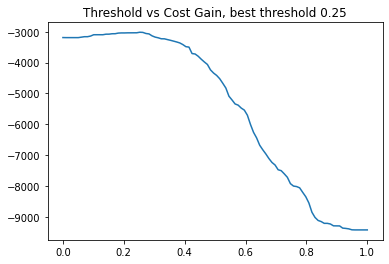

In [51]:
tuned_model = TunedThresholdClassifierCV(
    estimator=model,
    scoring=scoring["cost_gain"],
    store_cv_results=True,  # necessary to inspect all results
)
tuned_model.fit(X_train, y_train)
plt.plot(tuned_model.cv_results_['thresholds'], tuned_model.cv_results_['scores'])
plt.title("Threshold vs Cost Gain, best threshold {:.2f}".format(tuned_model.best_threshold_))
plt.show()


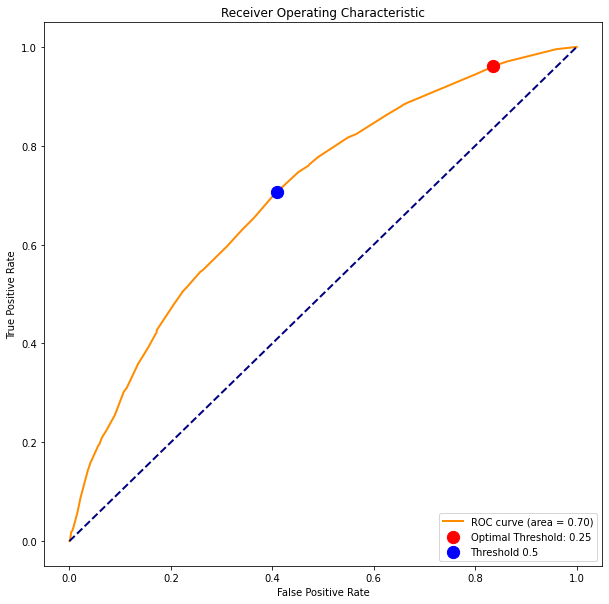

In [52]:

plt.figure(figsize=(10, 10))
best_threshold= tuned_model.best_threshold_
y_pred_proba = tuned_model.predict_proba(X_test)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
# Buscar el índice del umbral óptimo

#Busco el mas cercano
idx_op = np.abs(thresholds - best_threshold).argmin()

idx_05 = (np.abs(thresholds - 0.5)).argmin()


plt.scatter(fpr[idx_op], tpr[idx_op], color='red', s=150 ,label='Optimal Threshold: %0.2f' % best_threshold, zorder=5)
plt.scatter(fpr[idx_05], tpr[idx_05], color='blue', s=150, label='Threshold 0.5', zorder=5)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


In [53]:
print(f"Metrica definida por el negocio: {scoring['cost_gain'](tuned_model, X_test, y_test)}")

Metrica definida por el negocio: -6432


Precision - Recall - Threshold

In [66]:
ppdf = pd.DataFrame({"y_test":y_test, 
                     "y_proba_c0":model.predict_proba(X_test)[:, 0],
                     "y_proba_ci":model.predict_proba(X_test)[:, 1]})

In [69]:
ppdf.sort_values(by='y_proba_ci', ascending=False, inplace=True)
ppdf

,y_test,y_proba_c0,y_proba_ci
42491,0,0.000000,1.000000
35820,0,0.000000,1.000000
12841,1,0.000000,1.000000
15942,1,0.000000,1.000000
17844,1,0.000000,1.000000
...,...,...,...
38469,0,0.929245,0.070755
34438,0,0.929245,0.070755
39236,0,0.929245,0.070755
45311,0,0.929245,0.070755


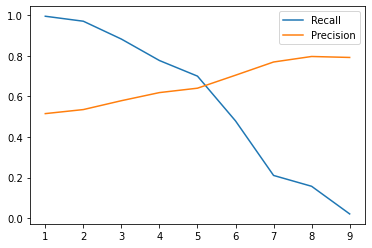

In [73]:
from sklearn.metrics import precision_score
recalls = []
precisions = []
for i in range(1, 10):
    threshold = i / 10
    ppdf[f"y_pred_{threshold}"] = ppdf["y_proba_ci"] > threshold
    recalls.append(recall_score(ppdf["y_test"], ppdf[f"y_pred_{threshold}"]))
    precisions.append(precision_score(ppdf["y_test"], ppdf[f"y_pred_{threshold}"]))

plt.plot(range(1, 10), recalls, label="Recall")
plt.plot(range(1, 10), precisions, label="Precision")
plt.legend()
plt.show()


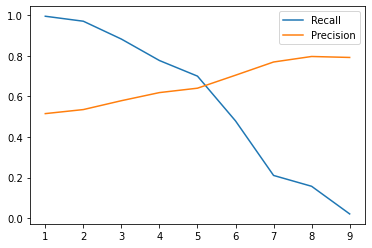